# Downstream Training 

## Load Ground Truth

In [3]:
import csv
from tqdm import tqdm

label_dict = {}
with open("ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]


Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3816472.98it/s]


## Import Sound Model from Huggingface

### Wav2vec
Huggingface: https://huggingface.co/facebook/wav2vec2-base-960h

In [13]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [14]:
from transformers import AutoProcessor, Wav2Vec2Model
import torch

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

Test Model


In [10]:
!pip install librosa


  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)

   ---------------- ----------------------- 2/5 [audioread]
   ------------------------ --------------- 3/5 [pooch]
   -------------------------------- ------- 4/5 [librosa]
   -------------------------------- ------- 4/5 [librosa]
   ---------------------------------------- 5/5 [librosa]



In [ ]:
import librosa

input_file = "ppl_dataset/devel_0074.wav"
waveform, sr = librosa.load(input_file, sr=16000)  

inputs = processor(waveform, sampling_rate=16000, return_tensors="pt")

inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs).last_hidden_state

print(outputs.shape)  # torch.Size([1, seq_len, 768])


torch.Size([1, 430, 768])


### Whisper
Huggingface: https://huggingface.co/openai/whisper-small

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="openai/whisper-small")

In [ ]:
import torch
from transformers import WhisperProcessor, WhisperModel

processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperModel.from_pretrained("openai/whisper-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## Generating Embeddings

In [22]:
import os
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_root = "ppl_dataset/"
output_root = "embeddings_ppl/"

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device).eval()

for split in ["train", "val", "test"]:
    input_dir = os.path.join(input_root, split)
    output_dir = os.path.join(output_root, split)
    os.makedirs(output_dir, exist_ok=True)

    wav_files = [f for f in os.listdir(input_dir) if f.endswith(".wav")]
    print(f"[{split}] Found {len(wav_files)} wav files")

    for filename in tqdm(wav_files, desc=f"Processing {split}"):
        wav_path = os.path.join(input_dir, filename)

        waveform, sr = librosa.load(wav_path, sr=16000)

        inputs = processor(waveform, sampling_rate=16000, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            hidden_states = model(**inputs).last_hidden_state
            embedding = hidden_states.mean(dim=1)  # shape: (1, 768)

        save_path = os.path.join(output_dir, filename.replace(".wav", ".npy"))
        np.save(save_path, embedding.cpu().squeeze().numpy())


Using device: cuda


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[train] Found 8 wav files


Processing train: 100%|██████████| 8/8 [00:00<00:00, 50.05it/s]


[val] Found 3 wav files


Processing val: 100%|██████████| 3/3 [00:00<00:00, 59.17it/s]


[test] Found 8 wav files


Processing test: 100%|██████████| 8/8 [00:00<00:00, 55.60it/s]


## Load Embeddings

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import glob


def load_single_acoustic_embedding(npy_file):
    basename = os.path.splitext(os.path.basename(npy_file))[0]  
    embedding = np.load(npy_file)
    return basename, embedding

def load_acoustic_embeddings(embedding_dir: str):
    npy_files = glob.glob(os.path.join(embedding_dir, "*.npy"))

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_single_acoustic_embedding, npy_files),
                            total=len(npy_files),
                            desc="Loading acoustic embeddings"))

    embedding_dict = dict(results)
    print(f"✅ Loaded {len(embedding_dict)} embeddings.")
    print(f"🧪 Sample shape: {next(iter(embedding_dict.values())).shape}")
    return embedding_dict

In [24]:
embedding_dir = "embeddings_ppl/"
val_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "val"))
test_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "test"))
train_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "train"))

Loading acoustic embeddings: 100%|██████████| 3/3 [00:00<00:00, 2998.79it/s]


✅ Loaded 3 embeddings.
🧪 Sample shape: (768,)


Loading acoustic embeddings: 100%|██████████| 8/8 [00:00<?, ?it/s]


✅ Loaded 8 embeddings.
🧪 Sample shape: (768,)


Loading acoustic embeddings: 100%|██████████| 8/8 [00:00<?, ?it/s]

✅ Loaded 8 embeddings.
🧪 Sample shape: (768,)


## Search in Ground Truth


In [25]:
def search_in_ground_truth(file_id: str, label_dict: dict) -> str:
    wav_name = file_id + ".wav"
    return label_dict.get(wav_name, None)


Test

In [ ]:
label = search_in_ground_truth("train_9493", label_dict)
print(label)  


C


## Downstream Network

In [27]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

Hyperparameter

In [29]:
# Model hyperparameters
model_params = {
    'input_size': 320,    # ESM2 embedding dimension
    'output_size': 1,     
    'hidden_size': 128,   
    'num_layers': 2       
}

# Training hyperparameters
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'num_epochs': 100,
    'dropout_rate': 0.2
}

# Early stopping parameters
early_stopping_params = {
    'patience': 10,
    'min_delta': 0.001
}

### FCN

In [47]:
import torch
import torch.nn as nn

class ColdPredictor(nn.Module):
    def __init__(self, input_size=768, hidden_size=512, dropout=0.3):
        super(ColdPredictor, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        self.output = nn.Linear(hidden_size // 2, 1) 

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.drop1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.drop2(x)

        x = self.output(x)
        return x


## Training

In [48]:
model = ColdPredictor(input_size=768).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = next(model.parameters()).device

# ✅ Training Loop
num_epochs = 10

### Data Loader


In [49]:
from torch.utils.data import Dataset
import torch

class ColdDetectionDataset(Dataset):
    """
    Dataset for cold detection task using audio embeddings.
    Each sample = (embedding, binary label)
    """
    def __init__(self, embedding_dict, label_dict):
        self.samples = []

        for file_id, emb in embedding_dict.items():
            wav_name = file_id + ".wav"
            if wav_name in label_dict:
                label = 1 if label_dict[wav_name] == "C" else 0
                self.samples.append((
                    torch.tensor(emb, dtype=torch.float32),
                    torch.tensor(label, dtype=torch.long)
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [ ]:
from torch.utils.data import DataLoader

train_dataset = ColdDetectionDataset(train_embeddings_dict, label_dict)
val_dataset   = ColdDetectionDataset(val_embeddings_dict, label_dict)

training_params = {
    'batch_size': 32,
    'num_workers': 0  
}

train_loader = DataLoader(
    train_dataset,
    batch_size=training_params['batch_size'],
    shuffle=True,
    num_workers=training_params['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=training_params['batch_size'],
    shuffle=False,
    num_workers=training_params['num_workers'],
    pin_memory=True
)


"\ntest_loader = DataLoader(\n    test_embeddings_dict,\n    batch_size=training_params['batch_size'],\n    shuffle=False,\n    num_workers=training_params['num_workers'],\n    pin_memory=True\n)\n"

### Training Loop


In [51]:
import time

best_val_loss = float('inf')
patience = 25
patience_counter = 0
training_losses = []
validation_losses = []
start_time = time.time()

print("Starting training...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    print(f'\n{"="*80}')
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'{"="*80}\n')

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")

    for batch_X, batch_y in progress_bar:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward
        optimizer.zero_grad()
        logits = model(batch_X).squeeze()
        loss = criterion(logits, batch_y.float())

        # Backward
        loss.backward()
        optimizer.step()

        # 统计
        preds = (torch.sigmoid(logits) > 0.5).long()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

        running_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)


    # 验证
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validating"):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze()
            loss = criterion(logits, batch_y.float())
            val_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).long()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)

    print(f"\nEpoch [{epoch+1}] Summary:")


    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_cold_model.pth")
        print("✅ Saved best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}")
            break

print(f"\n🎉 Training complete in {(time.time() - start_time)/60:.2f} min")


Starting training...


Epoch [1/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 257.75it/s]



Epoch [1] Summary:
✅ Saved best model

Epoch [2/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 498.49it/s]



Epoch [2] Summary:
✅ Saved best model

Epoch [3/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 274.26it/s]



Epoch [3] Summary:
✅ Saved best model

Epoch [4/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 254.26it/s]



Epoch [4] Summary:
✅ Saved best model

Epoch [5/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 285.27it/s]



Epoch [5] Summary:
✅ Saved best model

Epoch [6/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 181.28it/s]



Epoch [6] Summary:
✅ Saved best model

Epoch [7/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 249.97it/s]



Epoch [7] Summary:
✅ Saved best model

Epoch [8/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 166.50it/s]



Epoch [8] Summary:
✅ Saved best model

Epoch [9/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 199.75it/s]



Epoch [9] Summary:
✅ Saved best model

Epoch [10/10]



Validating: 100%|██████████| 1/1 [00:00<00:00, 352.97it/s]


Epoch [10] Summary:
✅ Saved best model

🎉 Training complete in 0.01 min


Visualization


✅ Epochs completed: 10 / Defined: 10
📁 Saved loss curve and CSV


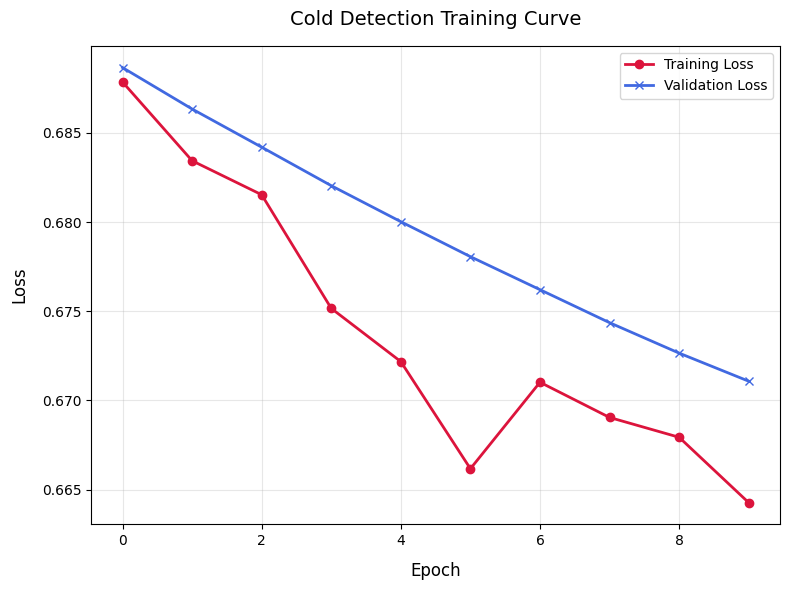

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8, 6))
plt.plot(training_losses, label='Training Loss', color='crimson', marker='o', linewidth=2, markersize=6)
plt.plot(validation_losses, label='Validation Loss', color='royalblue', marker='x', linewidth=2, markersize=6)

plt.title('Cold Detection Training Curve', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

print(f"✅ Epochs completed: {len(training_losses)} / Defined: {num_epochs}")

loss_df = pd.DataFrame({
    "epoch": list(range(1, len(training_losses) + 1)),
    "training_loss": training_losses,
    "validation_loss": validation_losses
})
loss_df.to_csv("cold_training_loss.csv", index=False)
print("📁 Saved loss curve and CSV")


## Test Set

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print("\n🚀 Starting testing...")
model.eval()

test_dataset = ColdDetectionDataset(test_embeddings_dict, label_dict)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_preds = []
test_labels = []

with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Testing",
              unit="samples",
              ncols=100) as progress_bar:
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze() 
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(batch_y.cpu().tolist())

            progress_bar.update(batch_X.size(0))

acc = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ Test F1 Score: {f1:.4f}")
